In [2]:
from mb_sql.conn import get_engine, get_session
from mb_sql.sql import read_sql
from mb_sql.utils import list_schemas,list_tables

In [3]:
engine = get_engine(name='postgresql' , db= 'postgres', user='postgres' , password= 'postgres', host= 'localhost', port= 5432, echo=False)
session = get_session(engine)

In [4]:
print(list_schemas(engine),f'\n\n',list_tables(engine, schema='public'))

    schema_name
0  embeddingsDB
1    pg_catalog
2      pg_toast
3        public
4      ytshorts 

        table_name
0     download_db
1  download_queue
2       merged_db
3    mix_video_db
4   transcript_db


In [5]:
read_sql('''SELECT
    column_name,
    data_type,
    character_maximum_length,
    is_nullable,
    column_default
FROM information_schema.columns
WHERE table_name = 'download_db'
ORDER BY ordinal_position;''', engine)

,column_name,data_type,character_maximum_length,is_nullable,column_default
0,yt_link,text,None,NO,None
1,local_link,text,None,YES,None
2,download,boolean,None,YES,None
3,date,date,None,YES,None
4,time,time without time zone,None,YES,None


In [6]:
read_sql('SELECT * FROM public.download_db limit 3;', engine)

,yt_link,local_link,download,date,time
0,https://www.youtube.com/watch?v=_nPQk65D3xE,/home/malav/Desktop/ytshorts_files/yt_download...,True,2025-05-23,02:04:29.359650
1,https://www.youtube.com/watch?v=_nPQk65D3xE,/home/malav/Desktop/ytshorts_files/yt_download...,True,2025-05-23,02:13:34.967209
2,https://www.youtube.com/watch?v=_nPQk65D3xE,/home/malav/Desktop/ytshorts_files/yt_download...,True,2025-05-23,02:16:29.363057


In [7]:
data = read_sql('SELECT * FROM public.download_db limit 3;', engine)
print(data.head(2))

                                       yt_link  \
0  https://www.youtube.com/watch?v=_nPQk65D3xE   
1  https://www.youtube.com/watch?v=_nPQk65D3xE   

                                          local_link  download        date  \
0  /home/malav/Desktop/ytshorts_files/yt_download...      True  2025-05-23   
1  /home/malav/Desktop/ytshorts_files/yt_download...      True  2025-05-23   

              time  
0  02:04:29.359650  
1  02:13:34.967209  


In [8]:
from mb_rag.agents.get_langsmith import set_langsmith_parameters

In [9]:
from mb_rag.utils.extra import load_dotenv
load_dotenv()

True

In [10]:
set_langsmith_parameters(langsmith_endpoint="https://api.smith.langchain.com",
                        langsmith_project="SQL-Agent-Project",
                        langsmith_tracing="true")

In [11]:
from mb_rag.agents.sql_agents import runtime_sql_agent,run_sql_agent

In [12]:
## testing engine
testing = runtime_sql_agent(engine)
testing.test_basic_mb()


    schema_name
0  embeddingsDB
1    pg_catalog
2      pg_toast
3        public
4      ytshorts 

        table_name
0     download_db
1  download_queue
2       merged_db
3    mix_video_db
4   transcript_db


In [13]:
from mb_rag.basic import ModelFactory

llm = ModelFactory(model_name="gemini-2.0-flash",model_type='google')
llm.invoke_query('What is the capital of France?')

/home/malav/.local/lib/python3.11/site-packages/pydantic/v1/main.py:1048: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


'The capital of France is **Paris**.'

In [14]:
main_agent = run_sql_agent(llm=llm.model,db_connection=engine,langsmith_params=False)

In [17]:
main_agent.run('List all tables in the database?')

[Agent Error] Expected dict, got List all tables in the database?
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_GRAPH_NODE_RETURN_VALUE


'Expected dict, got List all tables in the database?\nFor troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_GRAPH_NODE_RETURN_VALUE'

In [ ]:
# print(main_agent.agent.invoke({'input': 'List all tables in the database?'}))

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents: contents is not specified


In [9]:
from langchain_community.utilities.sql_database import SQLDatabase

In [10]:
db = SQLDatabase(engine=engine)

In [11]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm.model)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [12]:
system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

In [211]:
from langchain_core.callbacks  import BaseCallbackHandler
import time
from langchain.agents.middleware import wrap_model_call, wrap_tool_call,before_model,after_model,AgentMiddleware,AgentState,ModelRequest
from langgraph.runtime import Runtime

# @wrap_tool_call
# class DebugCallback(BaseCallbackHandler):
#     def __init__(self):
#         self.events = []

class LoggingMiddleware(AgentMiddleware):
    
    def before_model(
        self,
        state: AgentState,
        # runtime: Runtime,
        **kwargs,
    ) -> None:
        time_start = time.time()
        print(f"Inputs: {state}")
        state['additional_info'] = time_start
        print(f'New Info added to state:{state}')
        # print(f"Runtime complete: {runtime}")
        # print(f"Runtime info: {runtime.context.name}, {runtime.context.additional_info}")
        time_end = time.time()
        print(f"Time taken: {time_end - time_start} seconds")
        return None

    def after_model(self, state, runtime):
        # time_end = time.time()
        # time_start = state.get('additional_info', time_end)
        print(f"Model response: {state}")
        # print(f"Runtime info: {runtime.context.name}, {runtime.context.additional_info}")
        # print(f"Time taken: {time_end - time_start} seconds")
        return None

    def after_agent(self, state: AgentState, **kwargs) -> None:
        time_end = time.time()
        print(f"Agent ended. Time taken: {time_end - time.time()} seconds")
        print(f"Final state: {state}")
        return None
    
    def model_request(
        self,
        state: AgentState,
        request: ModelRequest,
        **kwargs,
    ) -> ModelRequest:
        print(f"Model request: {request}")
        return request


# @wrap_tool_call
@before_model
def on_chain_start(reqest, run_id=None, parent_run_id=None, tags=None, metadata=None, **kwargs):
    # print(f"Chain started with run_id: {run_id}")
    print(f'Time start : {time.time()}')
    time_start = time.time()
    print(f"Inputs: {reqest}")
    time_end = time.time()
    print(f"Time taken: {time_end - time_start} seconds")
    # return None
    # print(f"Inputs: {inputs}")
    # events= []
    # events.append({
    #     "event": "start",
    #     "run_id": run_id,
    #     "start_time": time.time(),
    #     "input": inputs,
    #     "metadata": metadata,
    # })

# @after_model(can_jump_to=['end'])
# @after_model(can_jump_to=['end'])
# def on_chain_end(outputs, run_id):
#     # print(f"Chain ended with outputs: ")
#     print(f"Outputs: {outputs}")
#     print(f"Run ID: {run_id}")

# callback = DebugCallback()

In [203]:
class Context:
    def __init__(self,name:str,additional_info:dict=None,table_info:str=None):
        self.name = name
        self.additional_info = additional_info
        self.table_info = table_info

In [258]:
from langchain.agents import create_agent

agent = create_agent(
    llm.model,
    tools,
    system_prompt=system_prompt,
    debug=False,
    middleware=[LoggingMiddleware(),SQLGuardRailsMiddleware()],
    # context_schema=db
    # context_schema=Context
)

In [261]:
question = "Give me 5 results of download_db?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    # context=Context(name="SQL_context_check", additional_info={"Test": "123"},table_info="download_db"),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Give me 5 results of download_db?
Inputs: {'messages': [HumanMessage(content='Give me 5 results of download_db?', additional_kwargs={}, response_metadata={}, id='74c59b7d-9788-4c95-bc61-62fb6b7b9ade')]}
New Info added to state:{'messages': [HumanMessage(content='Give me 5 results of download_db?', additional_kwargs={}, response_metadata={}, id='74c59b7d-9788-4c95-bc61-62fb6b7b9ade')], 'additional_info': 1762923487.0182188}
Time taken: 9.226799011230469e-05 seconds
================================== Ai Message ==================================

I need to know what tables are available in the database before I can query the `download_db` table.
Tool Calls:
  sql_db_list_tables (16db7fcb-fc22-401b-be43-3b3a16dadb4d)
 Call ID: 16db7fcb-fc22-401b-be43-3b3a16dadb4d
  Args:
[SQLGuardRailsMiddleware] Inspecting query: 
Model response: {'messages': [HumanMessage(content='Give me 5 results of download_db?', additi

In [23]:
from mb_rag.utils.viewer import display_graph_png

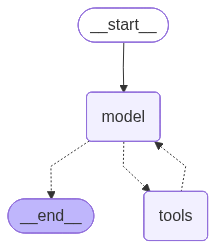

In [65]:
display_graph_png(agent)

In [257]:
from typing import Dict, Any
from langchain.messages import AIMessage
import json

class SQLGuardRailsMiddleware(AgentMiddleware):
    """
    Middleware to prevent SQL Modifications.
    """

    def _extract_sql_from_state(self, state: AgentState) -> str:
        messages = state.get("messages", [])
        for msg in reversed(messages):
            if isinstance(msg, AIMessage):
                fn_call = msg.additional_kwargs.get("function_call", {})
                if fn_call and fn_call.get("name") == "sql_db_query":
                    try:
                        args = json.loads(fn_call.get("arguments", "{}"))
                        return args.get("query", "")
                    except Exception as e:
                        print(f"[SQLGuardRailsMiddleware] Error parsing SQL args: {e}")
        return ""

    # @wrap_tool_call(tools=[toolkit.get_tools()])
    def after_model(self, state: AgentState, runtime: Runtime) -> Dict[str, Any]:
        input_query = self._extract_sql_from_state(state)
        query_upper = input_query.upper()
        print(f"[SQLGuardRailsMiddleware] Inspecting query: {input_query}")
        # ✅ block SELECT for test
        if "SELECT" in query_upper:
            print(f"[SQLGuardRailsMiddleware] Blocking SELECT query: {input_query}")
            return {
                "messages": [
                    AIMessage(content="SELECT queries are blocked for testing.")
                ],
                "jump_to": "end"
            }

        return None

In [23]:
from mb_rag.prompts_bank import PromptManager
from langchain.agents import create_agent
from langchain.tools import tool
import os

SYS_PROMPT = PromptManager().get_template("SQL_AGENT_SYS_PROMPT")
    
class run_sql_agent:
    """
    Create and return a SQL agent instance.
    
    Args:
        llm: The language model to use.
        db_connection: The database connection object with an `execute_query` method.
        sys_prompt: System prompt for the agent. (Defaults to SYS_PROMPT)
        langsmith_params: If True, enables LangSmith tracing.
        
    Returns:
        Configured SQL agent.
    """
    
    def __init__(self, llm, db_connection, sys_prompt=SYS_PROMPT, langsmith_params=True,use_mb: bool=True,logging =False):
        self.llm = llm
        self.db_connection = db_connection
        self.sys_prompt = sys_prompt
        self.use_mb = use_mb
        self.langsmith_params = langsmith_params
        self.logging = logging
        if logging:
            self.middleware = [LoggingMiddleware(), SQLGuardRailsMiddleware()]
        else:
            self.middleware = [SQLGuardRailsMiddleware()]

        if use_mb:
            from mb_rag.utils.extra import check_package
            check_package('mb_sql', 'Please install mb_sql package to use SQL agent with mb_sql: pip install -U mb_sql')
            from mb_sql.sql import read_sql
            from mb_sql.utils import list_schemas
            self.read_sql = read_sql
            self.list_schemas = list_schemas

        if not self.langsmith_params:
            os.environ["LANGCHAIN_TRACING"] = "false"
            print("LangSmith Tracing is disabled.")
        else:
            os.environ.setdefault("LANGCHAIN_TRACING", "true")
            self.langsmith_name = os.environ.get("LANGSMITH_PROJECT", "SQL-Agent-Project")
        self.agent = self.create_sql_agent()

    def create_sql_agent(self):
        """
        Create and configure the SQL agent.
        
        Returns:
            Configured SQL agent.
        """
        # from langchain_core.prompts import ChatPromptTemplate

        # from langchain_core.runnables import RunnableSequence

        # prompt = ChatPromptTemplate.from_template("{input}")
        # llm_chain = RunnableSequence(prompt, self.llm)

        if self.langsmith_params:
            from langsmith import traceable

            @traceable(run_type="chain", name=self.langsmith_name)
            def traced_agent():
                return create_agent(
                    system_prompt=self.sys_prompt,
                    tools=[SQLDatabaseTools(self.db_connection).to_tool_table_info(),
                           SQLDatabaseTools(self.db_connection).to_tool_text_to_sql(),
                           SQLDatabaseTools(self.db_connection).to_tool_execute_query(),
                           SQLDatabaseTools(self.db_connection).to_tool_database_schemas()],
                    model=self.llm,
                    context_schema=self.db_connection,
                    middleware=self.middleware
                    ).with_config({"recursion_limit": 50, 
                           'tags': ['sql-agent-with-trace'],
                           "metadata": {"user_id": "test_notebook_user"}
                           })

            return traced_agent()
        else:
            # No tracing
            return create_agent(
                system_prompt=self.sys_prompt,
                tools=[SQLDatabaseTools(self.db_connection).to_tool_table_info(),
                       SQLDatabaseTools(self.db_connection).to_tool_text_to_sql(),
                       SQLDatabaseTools(self.db_connection).to_tool_execute_query(),
                       SQLDatabaseTools(self.db_connection).to_tool_database_schemas()],
                model=self.llm,
                context_schema=self.db_connection,
                middleware=self.middleware
            ).with_config({"recursion_limit": 50, 
                           'tags': ['sql-agent-no-trace'],
                           "metadata": {"user_id": "test_notebook_user"}
                           })
        
    def run(self, query: str, stream: bool = False):
        """
        Run a SQL query using the configured agent.

        Args:
            query: User query string.
            stream: If True, stream the agent's reasoning step-by-step.

        Returns:
            Final state (stream mode) or the invoke() result.
        """
        try:
            if stream:
                final_state = None

                for step in self.agent.stream(
                    {"messages": [{"role": "user", "content": query}]},
                    stream_mode="values",
                ):
                    msg = step["messages"][-1]

                    # Built-in LangChain pretty print (no Rich)
                    if hasattr(msg, "pretty_print"):
                        msg.pretty_print()
                    else:
                        print(msg.content)

                    final_state = step

                return final_state

            result = self.agent.invoke(query)
            return result

        except Exception as e:
            print(f"[Agent Error] {e}")
            return str(e)

        
    def _save_to_db():
        """
        Save agent interactions to the given database.
        
        Returns:
            None
        """
        pass  # Implementation depends on specific database schema and requirements

In [24]:
from langchain.tools import tool
from typing import List, Optional
from langchain_community.utilities import SQLDatabase
from mb_rag.prompts_bank import PromptManager
from langchain_core.tools import StructuredTool
from mb_sql.sql import read_sql
from mb_sql.utils import list_schemas


class SQLDatabaseTools:
    """
    Class to handle SQL Database tools.
    """
    def __init__(self, db_connection):
        self.db_connection = db_connection
        self.read_sql = read_sql
        self.list_schemas = list_schemas

    def _get_database_schemas(self) -> List[str]:
        """
        Get the list of schemas in the database.

        Returns:
            List[str]: List of schema names.
        """
        return self.list_schemas(self.db_connection)
    
    def to_tool_database_schemas(self):
        return StructuredTool.from_function(
            func=self._get_database_schemas,
            name="get_database_schemas",
            description="Get list of schemas in the database",
        )

    def _get_table_info(self, table_name: str, schema_name: str) -> str:
        """
        Get information about a specific table in the database.

        Args:
            table_name: Name of the table to retrieve information for.
            schema_name: Name of the schema the table belongs to.
            use_mb: Whether to use mb_sql for execution.

        Returns:
            str: Information about the table.
        """
        query = '''SELECT
                    column_name,
                    data_type,
                    character_maximum_length,
                    is_nullable,
                    column_default
                FROM information_schema.columns
                WHERE table_name = '{table_name}' AND table_schema = '{schema_name}'
                ORDER BY ordinal_position;'''.format(table_name=table_name, schema_name=schema_name)
        # if use_mb:
        return {"results": self.read_sql(query, self.db_connection)}
        # else:
        #     import pandas as pd
        #     return {"results": pd.read_csv(query, self.db_connection)}
    
    def to_tool_table_info(self):
        return StructuredTool.from_function(
            func=self._get_table_info,
            name="get_table_info",
            description="Get column info for a table",
        )

    def _base_text_to_sql(text: str = None) -> str:
        """
        Convert natural language text to a SQL query.
        
        Args:
            text: Natural language description of the desired SQL query.

        Returns:
            str: Generated SQL query.
        """
        if text:
            prompt = text
        else:
            prompt_manager = PromptManager()
            prompt = prompt_manager.get_template("SQL_AGENT_SYS_PROMPT")
        return prompt
    
    def to_tool_text_to_sql(self):
        return StructuredTool.from_function(
            func=self._base_text_to_sql,
            name="text_to_sql",
            description="Convert natural language text to SQL query",
        )

    def _execute_query_tool(self,
                            query: str, 
                            ) -> str:
        """
        Execute a SQL query on the database.
        Args:
            query: SQL query string.
            use_mb: Whether to use mb_sql for execution.

        Returns:
            str: Result of the query execution.
        """
        try:
            # if use_mb:
            results = self.read_sql(query, self.db_connection)
            results = {'results': results}
            # else:
            #     results = self.db_connection.execute_query(query)
            #     results = {'results': results}
            return results
        except Exception as e:
            return f"Error executing query: {str(e)}"
        
    def to_tool_execute_query(self):
        return StructuredTool.from_function(
            func=self._execute_query_tool,
            name="execute_query",
            description="Execute a SQL query on the database",
        )

In [25]:

from typing import List,Optional,Dict,Any
import time
from langchain.agents.middleware import AgentMiddleware,AgentState,ModelRequest,ModelResponse
from langchain.messages import AIMessage
from langgraph.runtime import Runtime
import json


def timing_middleware(timer: int, state: AgentState) -> str:
    """
    Middleware to log the time taken for agent execution.
    Args:
        timer (int): The maximum time to wait for the agent to respond.
        state (AgentState): The state of the agent.
    Returns:
        str: The original input.
    """
    start_time = time.time()
    result = state.get("input", "")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"[TimingMiddleware] Agent execution time: {elapsed_time:.4f} seconds")
    return result

class SQLGuardRailsMiddleware(AgentMiddleware):
    """
    Middleware to prevent SQL Modifications.
    """
    def _extract_sql_from_state(self, state: AgentState) -> str:
        messages = state.get("messages", [])
        for msg in reversed(messages):
            if isinstance(msg, AIMessage):
                fn_call = msg.additional_kwargs.get("function_call", {})
                if fn_call and fn_call.get("name") == "sql_db_query":
                    try:
                        args = json.loads(fn_call.get("arguments", "{}"))
                        return args.get("query", "")
                    except Exception as e:
                        print(f"[SQLGuardRailsMiddleware] Error parsing SQL args: {e}")
        return ""
    
    def after_model(self, state: AgentState, runtime: Runtime) -> Dict[str, Any]:
        input_query = self._extract_sql_from_state(state)
        query_upper = input_query.upper()
        if any(op in query_upper for op in ["UPDATE", "DELETE", "INSERT", "DROP", "ALTER", "CREATE"]):
            print(f"[SQLGuardRailsMiddleware] SQL Table modification access detected: {input_query}")
            return {
                    "messages": [AIMessage("I cannot respond to that request as it involves modifying SQL tables.")],
                    "jump_to": "end"
            }
        return None
        

class LoggingMiddleware(AgentMiddleware):
    """
    Middleware to log agent interactions.
    """
    def before_model(self,state: AgentState) -> None:
        print(f"[LoggingMiddleware] Before model call with input: {state}")
        return None

    def after_model(self, state: AgentState) -> None:
        print(f"[LoggingMiddleware] After model call with output: {state}")
        return None
    
    def after_agent(self, state: AgentState) -> None:
        print(f"[LoggingMiddleware] After agent execution with final state: {state}")
        return None
    

In [26]:
main_agent = run_sql_agent(llm=llm.model,db_connection=engine,langsmith_params=False,logging=False)

LangSmith Tracing is disabled.


In [ ]:
# question = "Give me list of all tables in the database? If it has download_db table, give me 10 results from it."
# question = """Get the column names from public download_db. Give me top 5 results of that table."""
# main_agent.agent.invoke({"messages": [{"role": "user", "content": question}]},stream_mode=False)

[LoggingMiddleware] Before model call with input: {'messages': [HumanMessage(content='Get the column names from public download_db. Give me top 5 results of that table.', additional_kwargs={}, response_metadata={}, id='ad17a68b-5ab7-4bf5-9946-178abd2e94f4')]}
[LoggingMiddleware] After model call with output: {'messages': [HumanMessage(content='Get the column names from public download_db. Give me top 5 results of that table.', additional_kwargs={}, response_metadata={}, id='ad17a68b-5ab7-4bf5-9946-178abd2e94f4'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_table_info', 'arguments': '{"table_name": "download_db", "schema_name": "public"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='lc_run--d1206640-0c31-4d68-852d-86eb6ca6ad63-0', tool_calls=[{'name': 'get_table_info', 'args': {'table_name': 'download_db', 'schema_name': 'public'}, 'id': 'd1d9559e-5060-4e7e-814e-80c1270

[]

In [28]:
question = """Get the column names from public download_db. Give me top 5 results of that table which where created on 3rd date."""
for step in main_agent.agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    # context=Context(name="SQL_context_check", additional_info={"Test": "123"},table_info="download_db"),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Get the column names from public download_db. Give me top 5 results of that table which where created on 3rd date.
================================== Ai Message ==================================
Tool Calls:
  get_table_info (a81bcd98-b793-4054-bd94-d1e42ac3a7b2)
 Call ID: a81bcd98-b793-4054-bd94-d1e42ac3a7b2
  Args:
    table_name: download_db
    schema_name: public
================================= Tool Message =================================
Name: get_table_info

{'results':   column_name               data_type character_maximum_length is_nullable  \
0     yt_link                    text                     None          NO   
1  local_link                    text                     None         YES   
2    download                 boolean                     None         YES   
3        date                    date                     None         YES   
4        time  time without time zone     

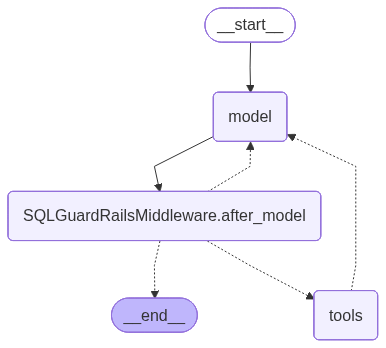

In [29]:
from mb_rag.utils.viewer import display_graph_png
display_graph_png(main_agent.agent)